# Model comparison with LOO 

In [1]:
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', 500)
az.style.use('arviz-darkgrid')

# Train/Test data
train = pd.read_csv('../../data/raw/train.csv').assign(data_type = 'train')
test = pd.read_csv('../../data/raw/test.csv').assign(data_type = 'test')

# Want to ensure the encodings of the neighbourhoods as indexes are consistent
df_full = train.append(test, ignore_index = True)
df_full['neighbourhood'] = df_full['Neighborhood'].astype('category').cat.codes+1

# Log variables
df_full['log_sales_price'] = np.log(df_full['SalePrice'])
df_full['log_lot_area'] = np.log(df_full['LotArea'])

# Train/test split
train = df_full.loc[df_full['data_type'] == 'train'].copy()
test = df_full.loc[df_full['data_type'] == 'test'].copy()

# Center and scale predictor (train)
train['log_lot_area_z'] = (train[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target (train)
train['log_sales_price_std'] = train['log_sales_price']/train['log_sales_price'].mean()

# Center and scale predictor using training data mean and std
test['log_lot_area_z'] = (test[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target using training data mean
test['log_sales_price_std'] = test['log_sales_price']/train['log_sales_price'].mean()

/Users/benjaminwee/anaconda/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Univariate model

In [2]:
ols = pystan.StanModel(file = '../../models/linear_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f624cc3d8d808ccfc509d79cb9030af5 NOW.


In [3]:
data = dict(N = len(train),
           log_sales_price = train['log_sales_price_std'],
           log_lot_area = train['log_lot_area_z'],
           x_test = test['log_lot_area_z'],
           N_test = len(test['log_lot_area_z']),
           alpha_sd = 0.01,
           beta_sd = 0.1,
           run_estimation = 1)

fit_ols = ols.sampling(data=data)
ols_df = fit_ols.to_dataframe()

RuntimeError: Exception: variable does not exist; processing stage=data initialization; variable name=log_lot_area_test; base type=vector_d  (in 'linear_model.stan' at line 11)


In [ ]:
ols_az = az.from_pystan(
    posterior=fit_ols,
    posterior_predictive="y_hat",
    observed_data=["log_sales_price"],
    log_likelihood='log_lik',
)

(-0.1, 1.5)

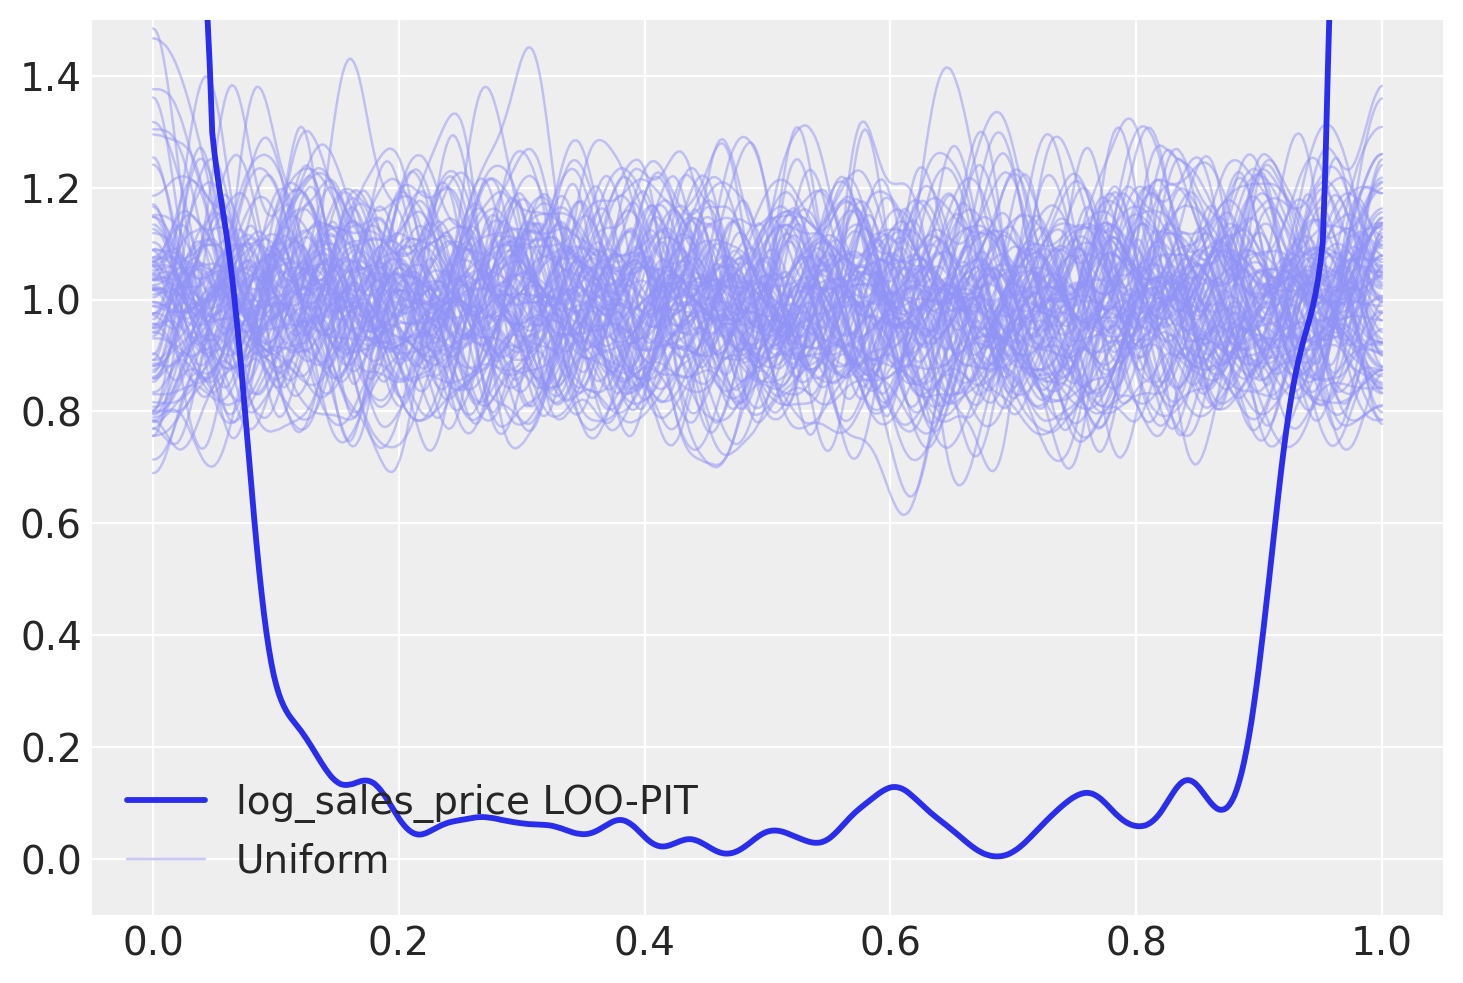

In [119]:
az.plot_loo_pit(idata=ols_az, y = 'log_sales_price', y_hat = 'y_hat')
plt.ylim(-0.1,1.5)

In [ ]:
az.loo(ols_az)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x14cde4eb8>],
      dtype=object)

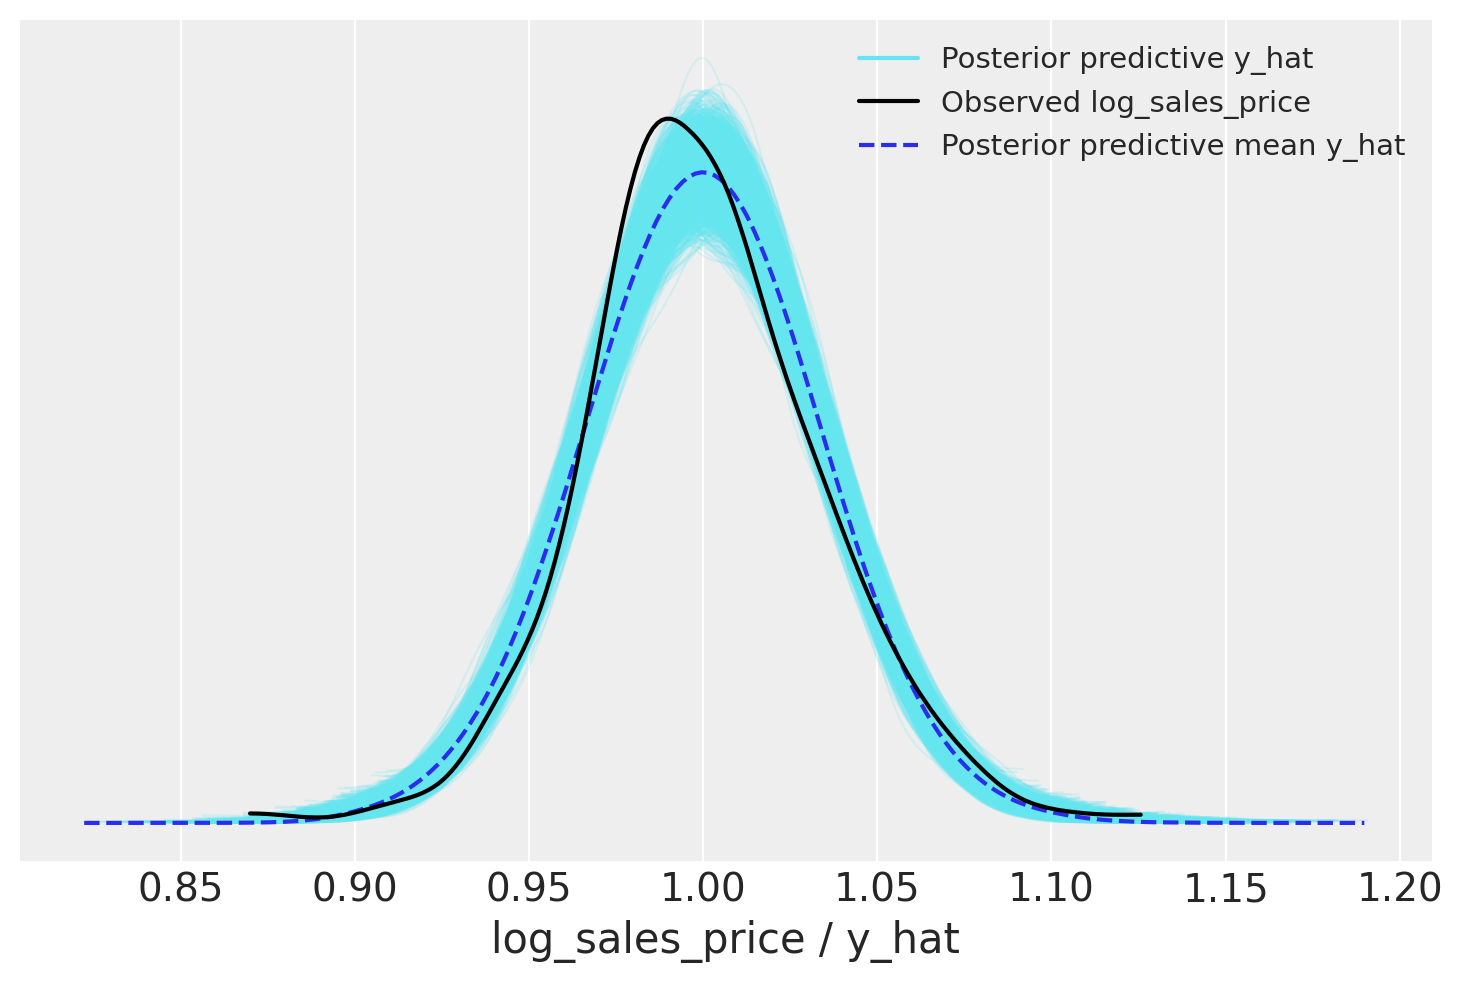

In [157]:
az.plot_ppc(data = ols_az, kind = 'density', data_pairs = {'log_sales_price' : 'y_hat'})

## No pooling model

In [107]:
npm = pystan.StanModel(file = '../../models/dummy_variable_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_158392d52f0d5ccb2cbf42a6f2271c61 NOW.


In [108]:
npm_data = dict(N = len(train),
              log_sales_price = train['log_sales_price_std'],
              log_lot_area = train['log_lot_area_z'],
              neighbourhood = train['neighbourhood'],
              N_neighbourhood = len(train['Neighborhood'].unique()),
              N_test = len(test),
              log_lot_area_test = test['log_lot_area_z'],
              neighbourhood_test = test['neighbourhood'],
              alpha_sd = 0.01, 
              beta_sd = 0.1, 
              run_estimation = 1)

fit_npm = npm.sampling(data=npm_data)
npm_df = fit_npm.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [110]:
npm_az = az.from_pystan(
    posterior=fit_npm,
    posterior_predictive="y_hat",
    observed_data=["log_sales_price"],
    log_likelihood='log_lik',
)

/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/stats/stats.py:714: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa


(-0.1, 1.5)

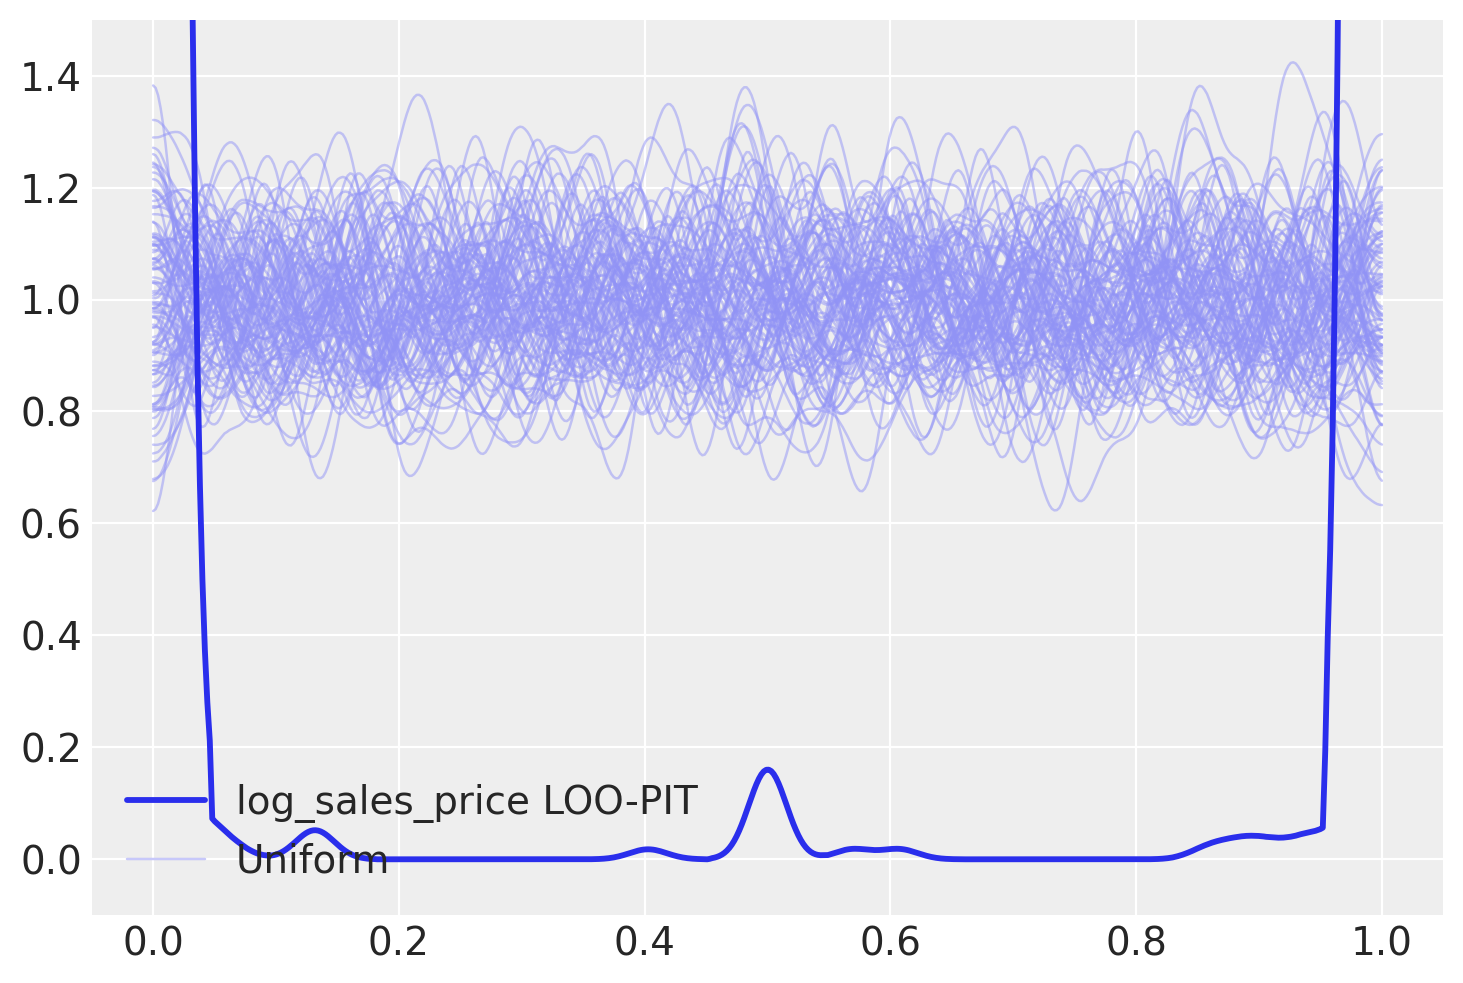

In [118]:
az.plot_loo_pit(idata=npm_az, y = 'log_sales_price', y_hat = 'y_hat')
plt.ylim(-0.1,1.5)

In [159]:
az.loo(npm_az)

/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/stats/stats.py:714: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/stats/stats.py:482: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 1460 log-likelihood matrix

       Estimate       SE
IC_loo -1326519.41  162453.06
p_loo  2076491.98        -

There has been a warning during the calculation. Please check the results.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x19aa66828>],
      dtype=object)

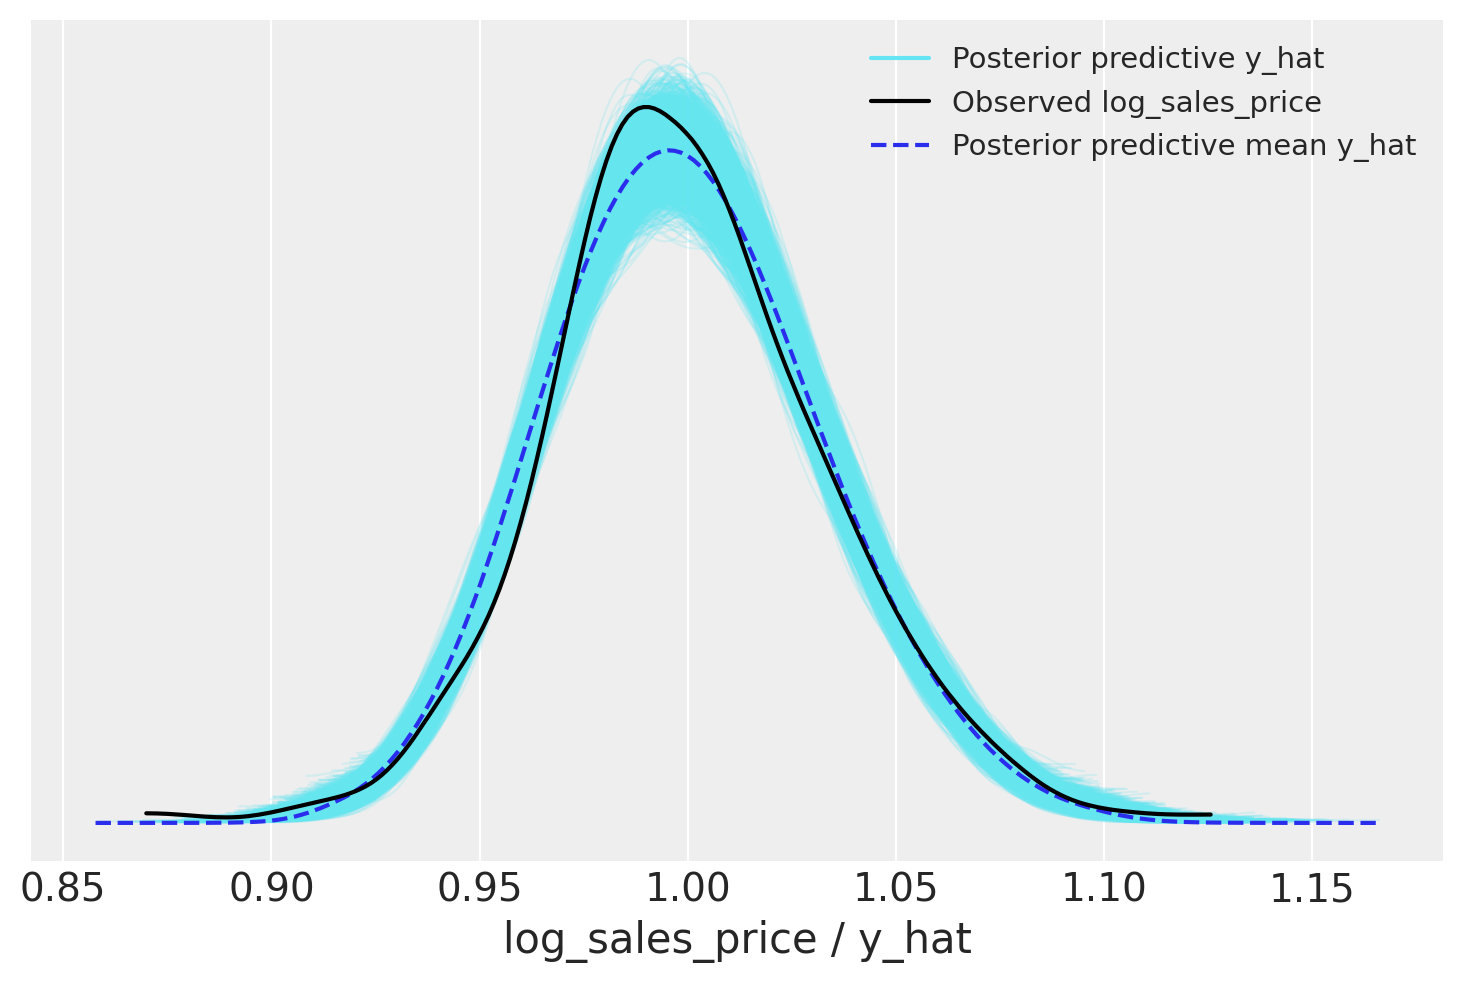

In [156]:
az.plot_ppc(data = npm_az, kind = 'density', data_pairs = {'log_sales_price' : 'y_hat'})

## Interactive Effects Model

In [22]:
iem = pystan.StanModel(file = '../../models/saturated_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f99889c2715e14b840c8576081c80d95 NOW.


In [23]:
iem_data = dict(N = len(train),
           log_sales_price = train['log_sales_price_std'],
           log_lot_area = train['log_lot_area_z'],
           neighbourhood = train['neighbourhood'],
           N_neighbourhood = len(train['Neighborhood'].unique()),
           N_test = len(test),
           log_lot_area_test = test['log_lot_area_z'],
           neighbourhood_test = test['neighbourhood'],
           alpha_sd = 0.01, 
           beta_sd = 0.1, 
           run_estimation = 1)

fit_iem = iem.sampling(data=iem_data)
fit_iem_df = fit_iem.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [111]:
iem_az = az.from_pystan(
    posterior=fit_iem,
    posterior_predictive="y_hat",
    observed_data=["log_sales_price"],
    log_likelihood='log_lik',
)

/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/stats/stats.py:714: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa


(-0.1, 1.5)

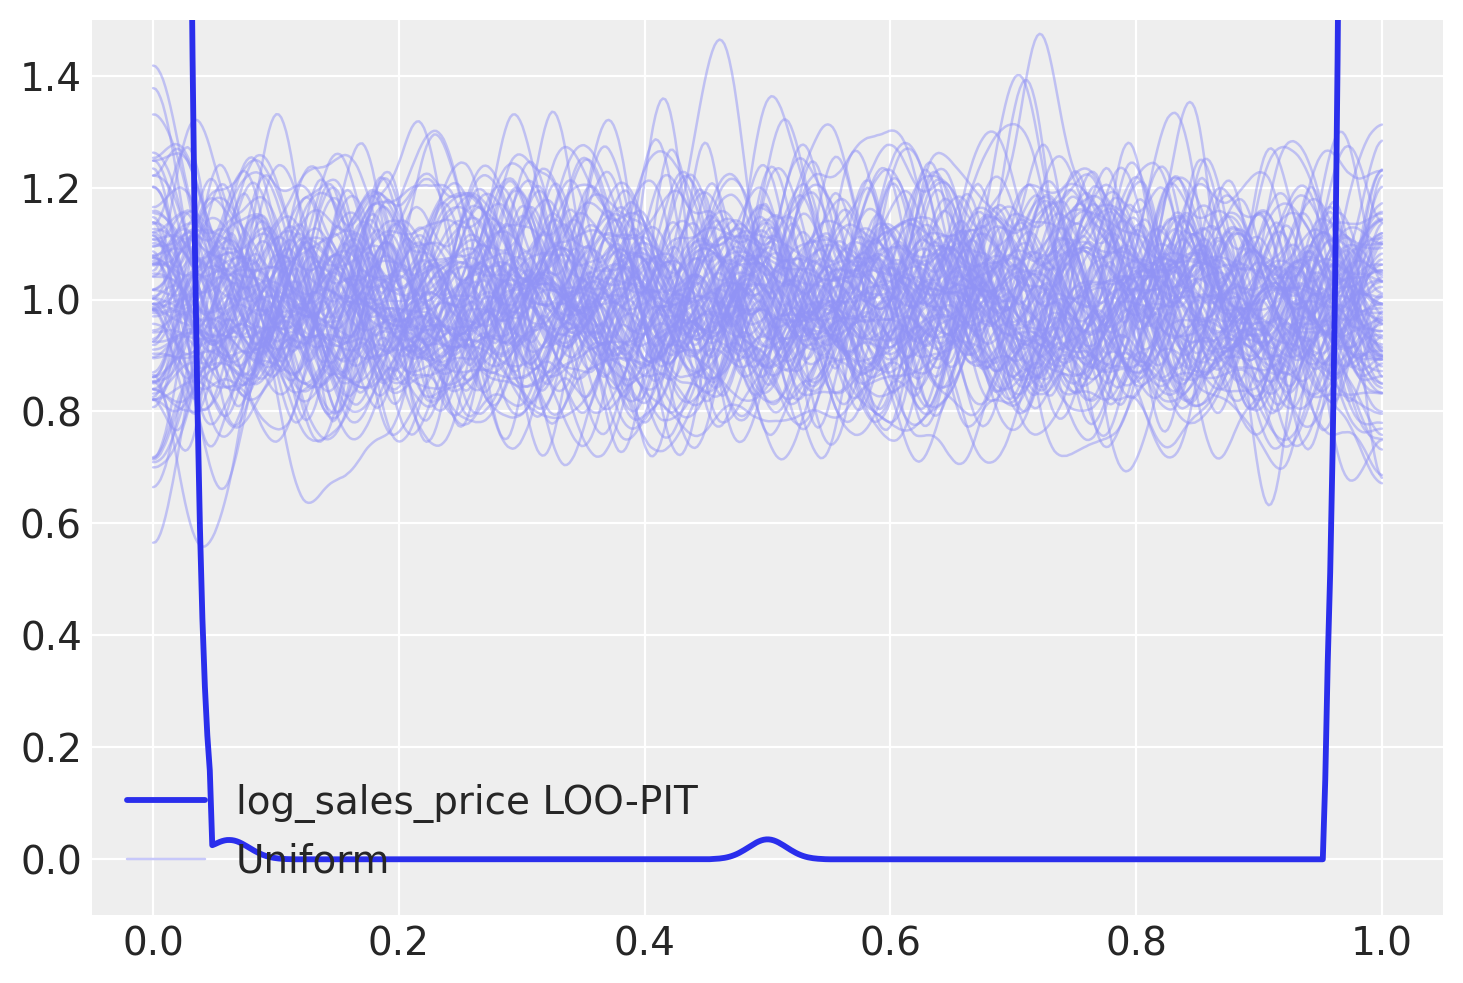

In [120]:
az.plot_loo_pit(idata=iem_az, y = 'log_sales_price', y_hat = 'y_hat')
plt.ylim(-0.1,1.5)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13f69c7f0>],
      dtype=object)

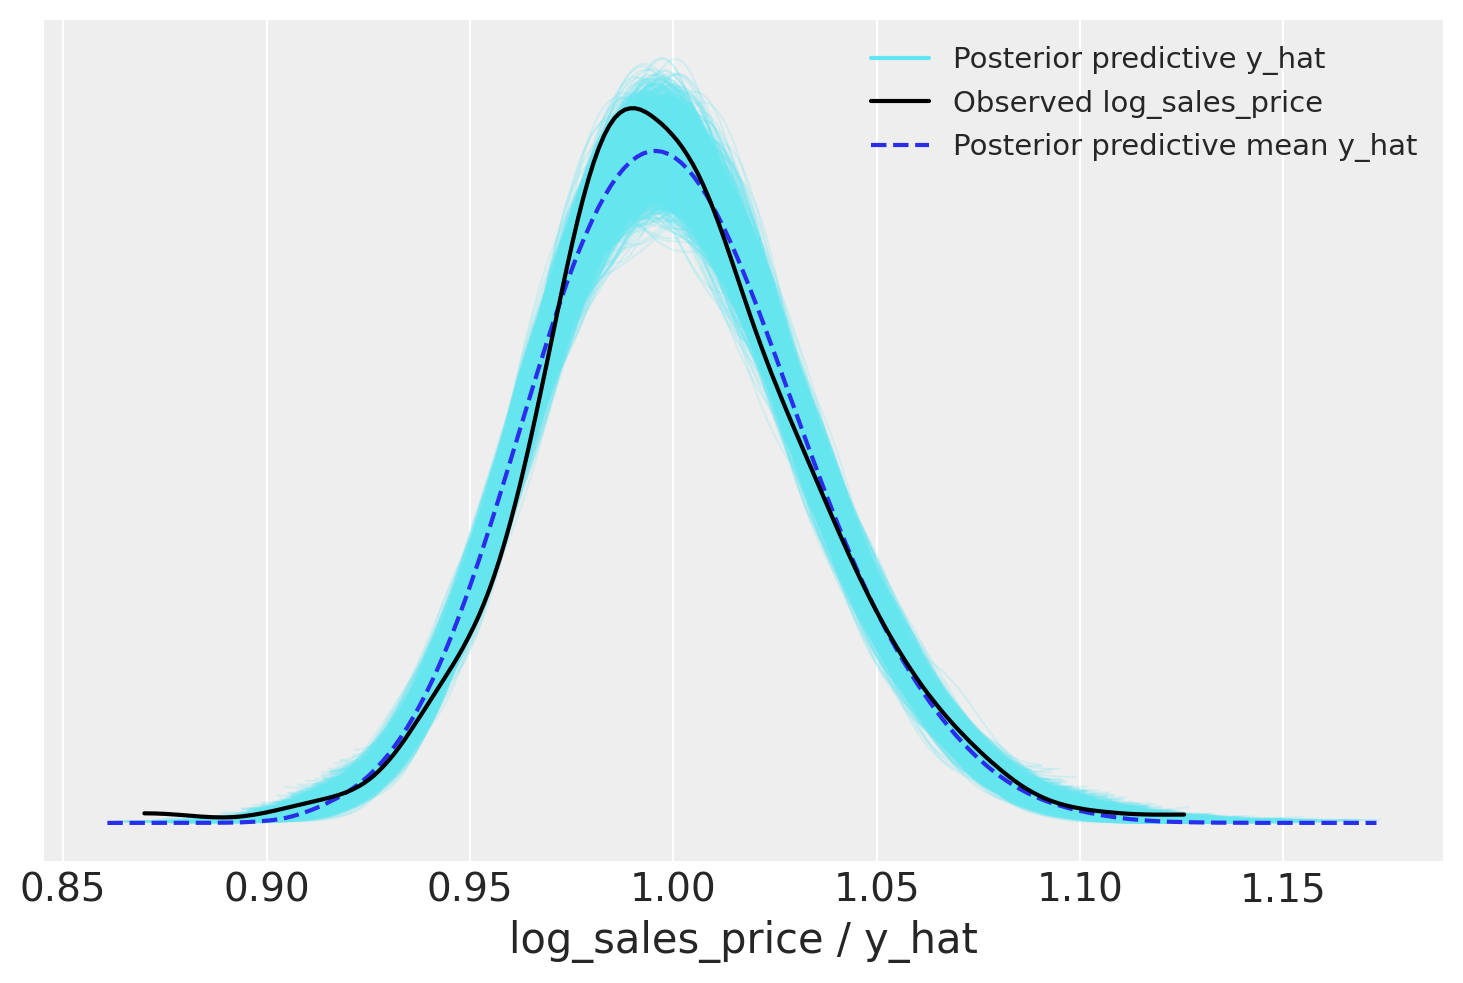

In [155]:
az.plot_ppc(data = iem_az, kind = 'density', data_pairs = {'log_sales_price' : 'y_hat'})

## Multilevel Intercepts

In [24]:
# Import multilevel model
mli = pystan.StanModel(file = '../../models/multilevel_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_00eeba72f2f20d138ee43a0ad4eb61a6 NOW.


In [28]:
mli_data = dict(N = len(train),
           log_sales_price = train['log_sales_price_std'],
           log_lot_area = train['log_lot_area_z'],
           neighbourhood = train['neighbourhood'],
           N_neighbourhood = len(train['Neighborhood'].unique()),
           N_test = len(test),
           log_lot_area_test = test['log_lot_area_z'],
           neighbourhood_test = test['neighbourhood'],
           beta_sd = 0.1, 
           run_estimation = 1)

fit_mli = mli.sampling(data=mli_data)
fit_mli_df = fit_mli.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [112]:
mli_az = az.from_pystan(
    posterior=fit_mli,
    posterior_predictive="y_hat",
    observed_data=["log_sales_price"],
    log_likelihood='log_lik',
)

(-0.1, 1.5)

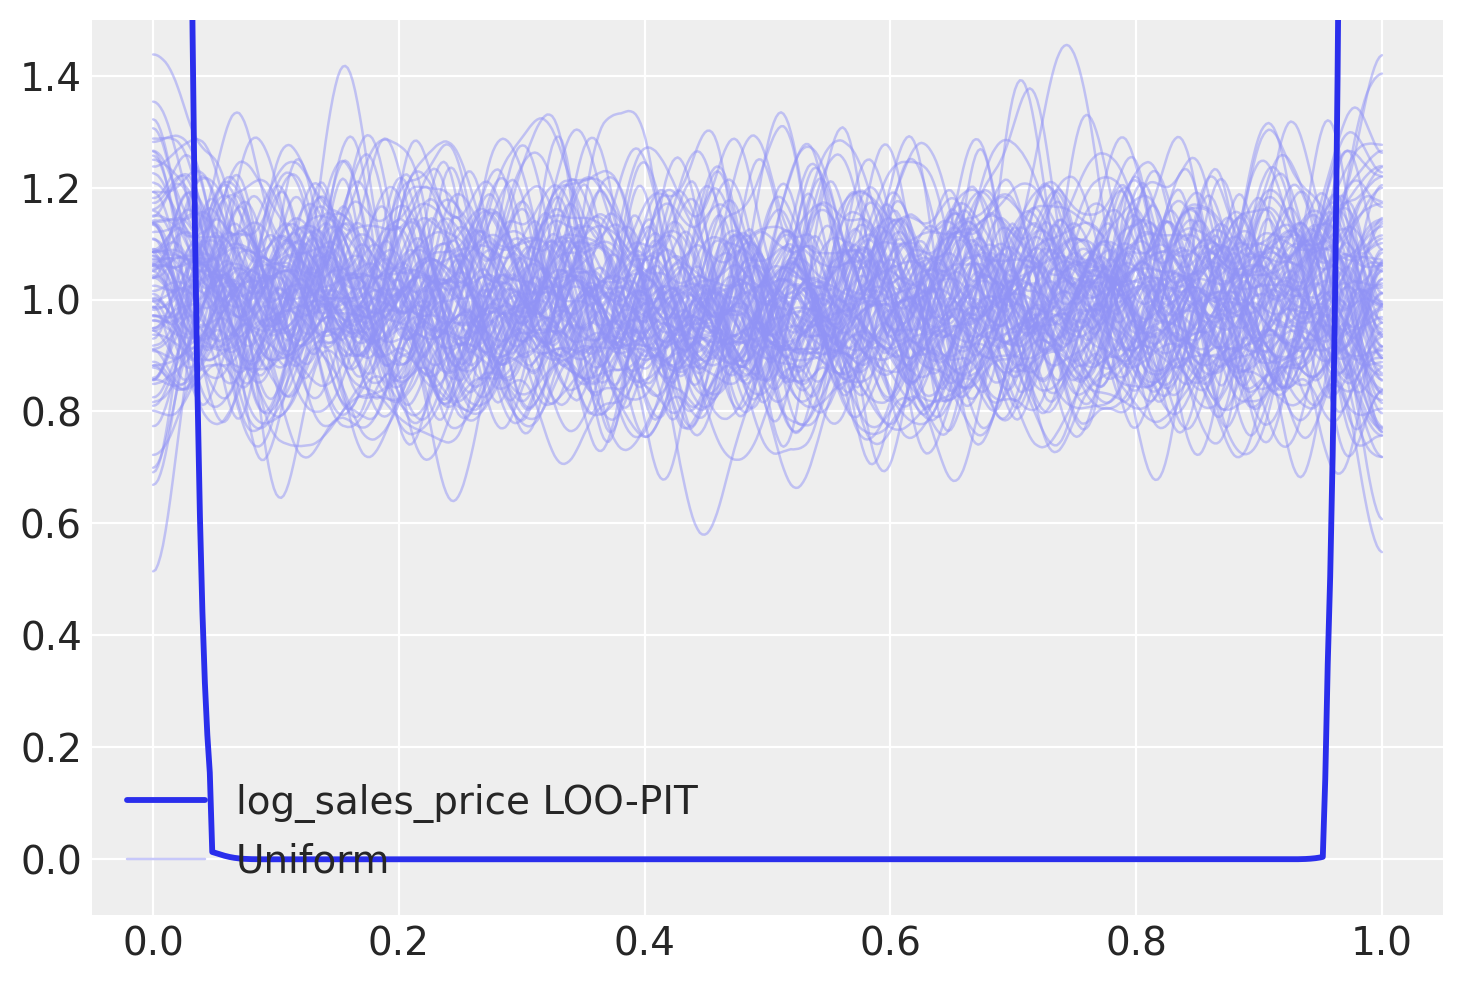

In [121]:
az.plot_loo_pit(idata=mli_az, y = 'log_sales_price', y_hat = 'y_hat')
plt.ylim(-0.1,1.5)

In [165]:
az.loo(mli_az, pointwise = True, scale = 'log')

/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/stats/stats.py:482: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 1460 log-likelihood matrix

         Estimate       SE
elpd_loo 340234.54  92853.85
p_loo    2288789.74        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad) 1460  100.0%

array([<matplotlib.axes._subplots.AxesSubplot object at 0x144681b38>],
      dtype=object)

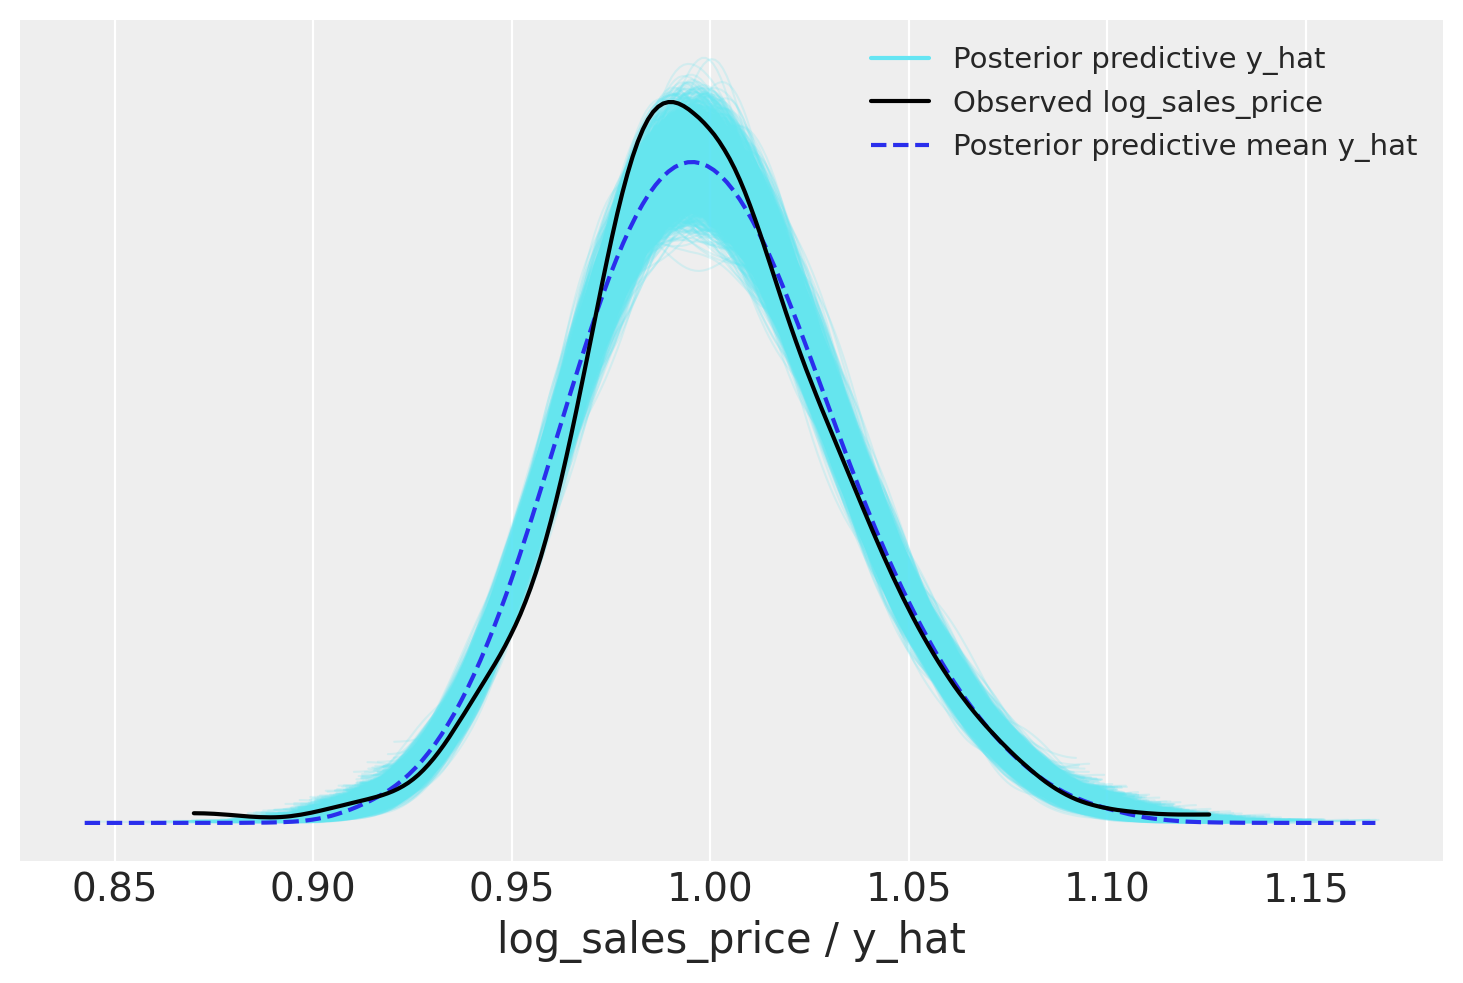

In [154]:
az.plot_ppc(data = mli_az, kind = 'density', data_pairs = {'log_sales_price' : 'y_hat'})

## Multilevel Slopes

In [4]:
# Import multilevel model
multilevel_slopes = pystan.StanModel(file = '../../models/multilevel_slopes.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7d35522334fb4d5920587d196b7b8985 NOW.


In [5]:
mls_data = dict(N = len(train),
           log_sales_price = train['log_sales_price_std'],
           log_lot_area = train['log_lot_area_z'],
           neighbourhood = train['neighbourhood'],
           N_neighbourhood = len(train['Neighborhood'].unique()),
           N_test = len(test),
           log_lot_area_test = test['log_lot_area_z'],
           neighbourhood_test = test['neighbourhood'],
           beta_sd = 0.5, 
           run_estimation = 1)

fit_mls = multilevel_slopes.sampling(data=mls_data)
fit_mls_df = fit_mls.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [6]:
mls_az = az.from_pystan(
    posterior=fit_mls,
    posterior_predictive="y_hat",
    observed_data="log_sales_price",
    log_likelihood='log_lik',
)

(-0.1, 1.5)

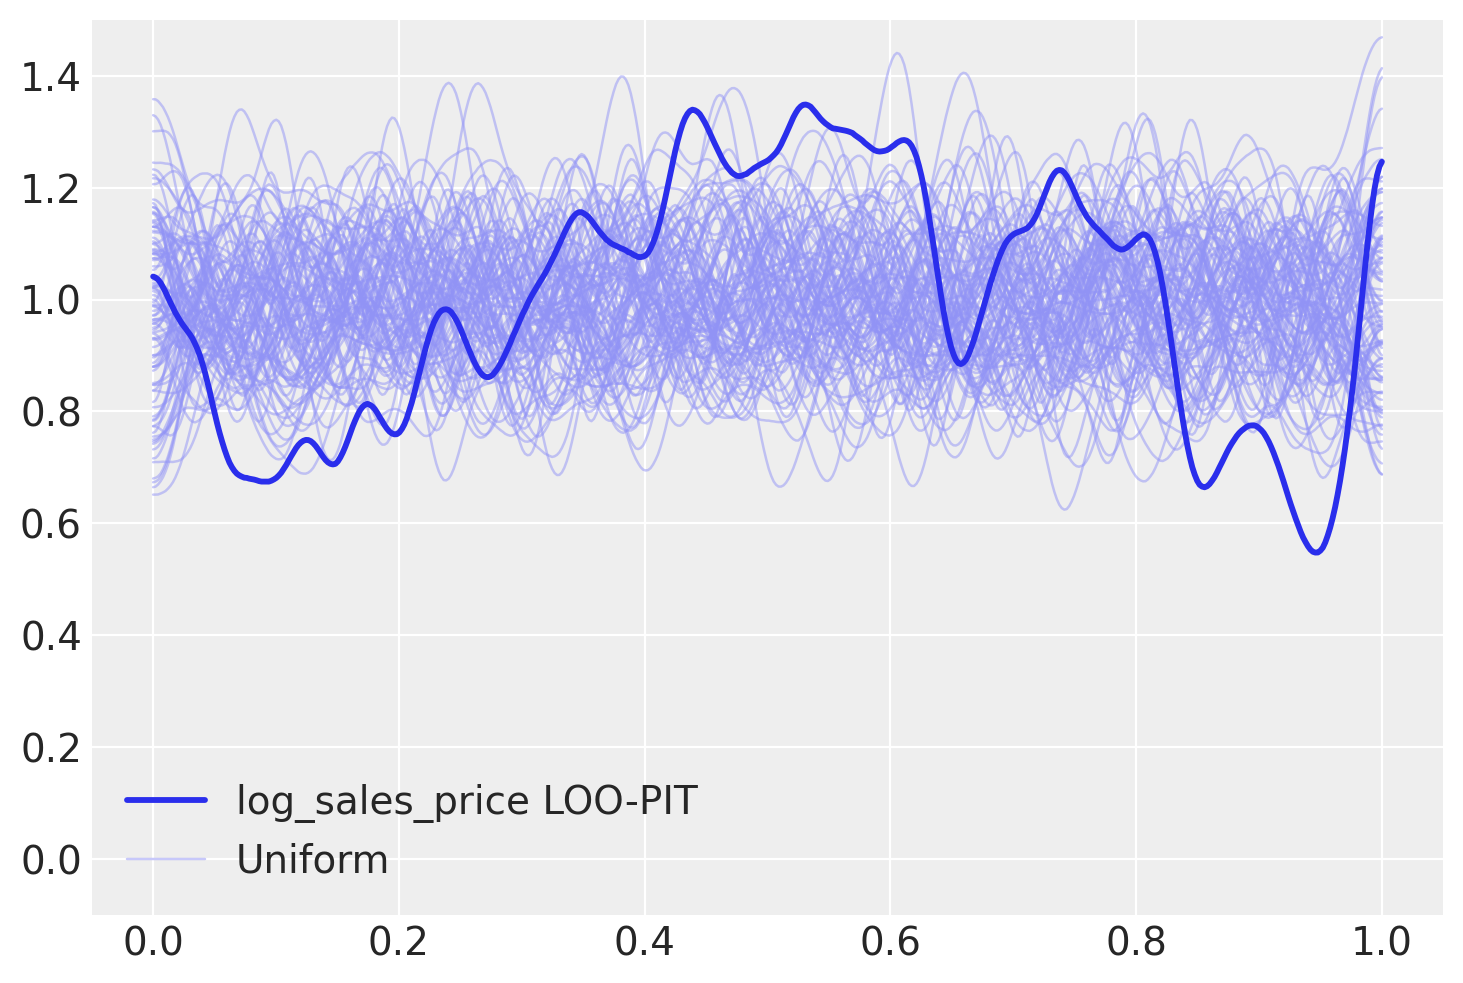

In [7]:
az.plot_loo_pit(idata=mls_az, y = 'log_sales_price', y_hat = 'y_hat')
plt.ylim(-0.1,1.5)

In [8]:
az.loo(mls_az, pointwise = True, scale = 'log')

Computed from 4000 by 1460 log-likelihood matrix

         Estimate       SE
elpd_loo  3653.40    38.64
p_loo       44.80        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1458   99.9%
 (0.5, 0.7]   (ok)          2    0.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1461189e8>],
      dtype=object)

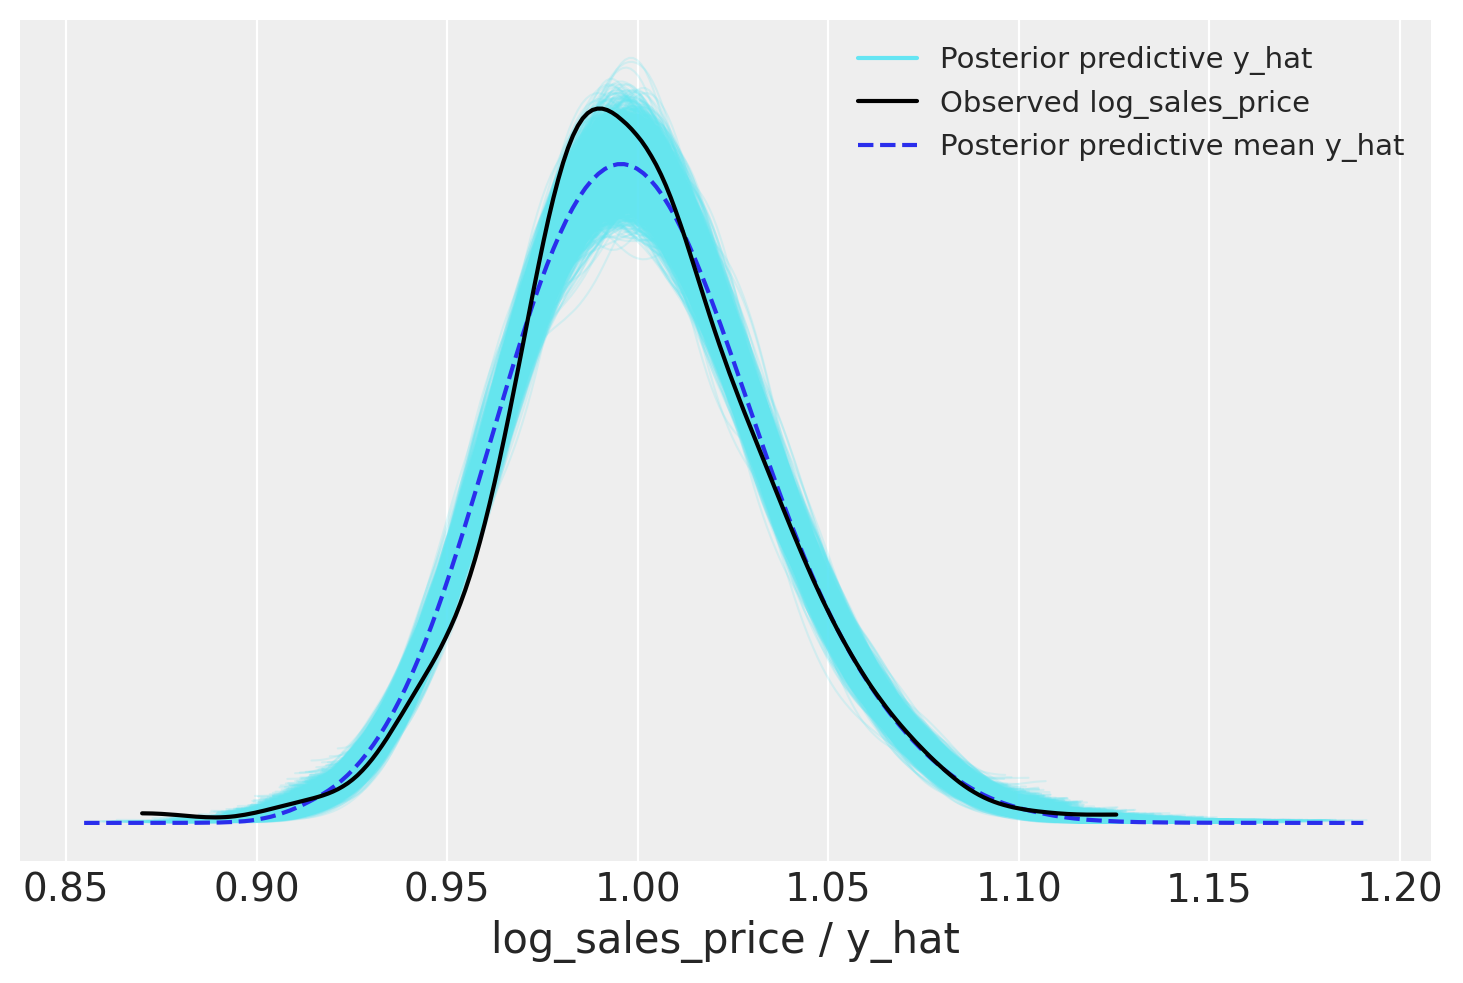

In [9]:
az.plot_ppc(data = mls_az, kind = 'density', data_pairs = {'log_sales_price' : 'y_hat'})

## LOO and WAIC

In [166]:
compare_dict = {"ols": ols_az, 
                "npm": npm_az,
                "iem": iem_az}

az.compare(compare_dict, ic="loo", scale = 'log')
 

/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/stats/stats.py:482: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/stats/stats.py:714: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/stats/stats.py:482: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to

rank         loo        p_loo        d_loo weight       se      dse  \
ols    0  3.8849e+06       223923            0    NaN  20066.7        0   
npm    1      663260  2.07649e+06  3.22164e+06    NaN  81634.3  73617.9   
iem    2      604753   2.1757e+06  3.28014e+06      0    87613  78768.6   

    warning loo_scale  
ols    True       log  
npm    True       log  
iem    True       log

In [125]:
compare_dict = {"ols": ols_az, 
                "npm": npm_az,
                "iem": iem_az}

az.compare(compare_dict, ic="waic")
 

/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


rank         waic       p_waic       d_waic weight           se  \
ols    0      -540526  3.83856e+06            0      1   1.3824e+06   
npm    1  2.27053e+08  1.16266e+08  2.27593e+08      0  1.24689e+07   
iem    2  2.50203e+08  1.27882e+08  2.50744e+08      0   2.1129e+07   

             dse warning waic_scale  
ols            0    True   deviance  
npm  1.15074e+07    True   deviance  
iem  1.93943e+07    True   deviance

In [126]:
compare_dict = {"ols": ols_az, 
                "npm": npm_az,
                "iem": iem_az,
                "mli": mli_az,
                "mls": mls_az}

az.compare(compare_dict, ic="loo", scale="log")
 

/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/stats/stats.py:482: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/stats/stats.py:714: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/stats/stats.py:482: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to

rank         loo        p_loo        d_loo weight       se      dse  \
ols    0  3.8849e+06       223923            0    NaN  20025.7        0   
npm    1      663260  2.07649e+06  3.22164e+06    NaN  80565.3  73617.9   
iem    2      604753   2.1757e+06  3.28014e+06    NaN  85447.4  78768.6   
mli    3      340235  2.28879e+06  3.54466e+06    NaN  91128.8  85425.8   
mls    4     3653.61      44.3906  3.88124e+06    NaN  38.0636  20052.4   

    warning loo_scale  
ols    True       log  
npm    True       log  
iem    True       log  
mli    True       log  
mls   False       log

In [128]:
compare_dict = {"ols": ols_az, 
                "npm": npm_az,
                "iem": iem_az,
                "mli": mli_az,
                "mls": mls_az}

az.compare(compare_dict, ic="waic", scale="deviance")
 

/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


rank         waic       p_waic       d_waic weight           se  \
ols    0      -540526  3.83856e+06            0  0.677  1.31619e+06   
mls    1     -7307.98      44.0056       533218  0.323  1.48734e+07   
npm    2  2.27053e+08  1.16266e+08  2.27593e+08      0      77.0627   
iem    3  2.50203e+08  1.27882e+08  2.50744e+08      0  1.23436e+07   
mli    4  2.72176e+08  1.38717e+08  2.72716e+08      0  2.03718e+07   

             dse warning waic_scale  
ols            0    True   deviance  
mls  1.34331e+06    True   deviance  
npm  1.15074e+07    True   deviance  
iem  1.93943e+07    True   deviance  
mli  1.41316e+07    True   deviance

In [130]:
compare_dict = {"ols": ols_az, 
                "npm": npm_az}
az.compare(compare_dict, ic="waic", scale="deviance")
 

/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


rank         waic       p_waic       d_waic weight           se  \
ols    0      -540526  3.83856e+06            0      1  1.33925e+06   
npm    1  2.27053e+08  1.16266e+08  2.27593e+08      0   1.2149e+07   

             dse warning waic_scale  
ols            0    True   deviance  
npm  1.15074e+07    True   deviance

In [83]:
az.from_pystan(fit_ols)

Inference data with groups:
	> posterior
	> sample_stats

In [99]:
stan_data = az.from_pystan(
    posterior=fit_ols,
    posterior_predictive="y_hat",
    observed_data=["log_sales_price"],
    log_likelihood='log_lik',
)
print(stan_data)

#idata_lognormal = az.from_pystan(
#    posterior=fit_lognormal,
#    posterior_predictive='y_hat',
#    observed_data=['y'],
#    log_likelihood={'y': 'log_lik'},
#)

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> observed_data


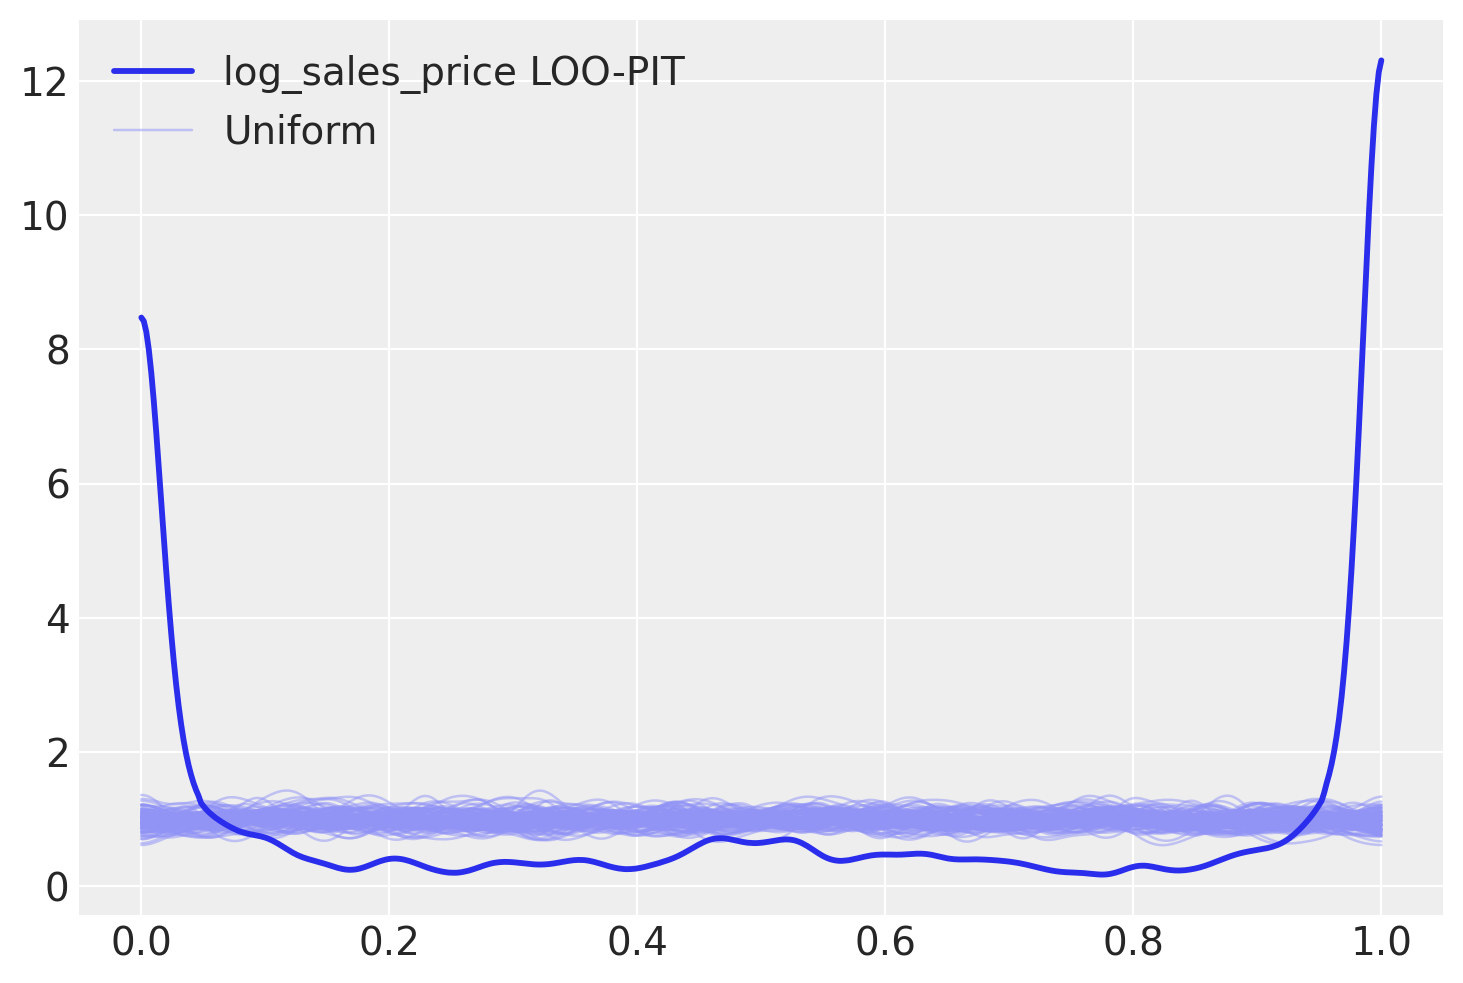

In [104]:
az.plot_loo_pit(idata=stan_data, y = 'log_sales_price', y_hat = 'y_hat')

In [67]:
az.plot_loo_pit

Signature: az.plot_loo_pit(idata=None, y=None, y_hat=None, log_weights=None, ecdf=False, ecdf_fill=True, n_unif=100, use_hpd=False, credible_interval=0.94, figsize=None, textsize=None, color='C0', legend=True, ax=None, plot_kwargs=None, plot_unif_kwargs=None, hpd_kwargs=None, fill_kwargs=None)
Docstring:
Plot Leave-One-Out (LOO) probability integral transformation (PIT) predictive checks.

Parameters
----------
idata : InferenceData
    InferenceData object.
y : array, DataArray or str
    Observed data. If str, idata must be present and contain the observed data group
y_hat : array, DataArray or str
    Posterior predictive samples for ``y``. It must have the same shape as y plus an
    extra dimension at the end of size n_samples (chains and draws stacked). If str or
    None, idata must contain the posterior predictive group. If None, y_hat is taken
    equal to y, thus, y must be str too.
log_weights : array or DataArray
    Smoothed log_weights. It must have the same shape as ``y_